In [3]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm

In [25]:
df  = pd.read_csv("spam.csv",encoding='latin-1')

In [33]:
df = df.iloc[:,[0,1]]

In [34]:
df.head(10)

,v1,Phrase
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [29]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [40]:
def clean_sentences(data):
    sms = []
    lemmatizer = WordNetLemmatizer()
    
    for sent in tqdm(data["Phrase"]):
        sent = sent.lower()
        
        clean_sent = sent.translate(str.maketrans('','',string.punctuation))
        word = word_tokenize(clean_sent)       
        only_word = [k for k in word if k not in stopwords.words("english")]
        
        cleaned_word = [lemmatizer.lemmatize(i) for i in only_word]
        
        sms.append(cleaned_word)
    
    return sms
        
    

In [41]:
clean_sms = clean_sentences(df)

100%|█████████████████████████████████████████████████████████████████████████████| 5572/5572 [00:53<00:00, 103.28it/s]


In [45]:
print(len(clean_sms))

5572


In [46]:
from keras.utils import to_categorical

In [54]:
y = df.v1
y = y.replace(to_replace='ham',value=0)
y = y.replace(to_replace="spam",value=1)
y = y.values
y = to_categorical(y)
num_class = y.shape[1]

In [58]:
unique_words =set()
len_max = 0

for sms in tqdm(clean_sms):
    unique_words.update(sms)
    
    if len_max<len(sms):
        len_max=len(sms)
        
        
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████████| 5572/5572 [00:00<00:00, 698507.44it/s]

8898
80


In [55]:
from sklearn.model_selection import train_test_split

In [57]:
x_train,x_test,y_train,y_test = train_test_split(clean_sms,y,test_size=0.2,stratify=y)

In [61]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [63]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_text = list(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_test = sequence.pad_sequences(x_test,maxlen=len_max)


In [64]:
from keras.callbacks import EarlyStopping

In [76]:
early_stopping = EarlyStopping(monitor = 'accuracy',patience=2)
callback = [early_stopping]

In [68]:
from keras.models import Sequential
from keras.layers import Embedding,Dense,Dropout,LSTM

In [77]:
model = Sequential()

model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class,activation='sigmoid'))

model.compile(optimizer='Adam',loss="binary_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 300)           2669400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 80, 128)           219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 2,942,746
Trainable params: 2,942,746
Non-trainable params: 0
____________________________________________

In [79]:
history = model.fit(x_train,y_train,callbacks=callback,epochs=15,batch_size=150)

Epoch 1/15
4457/4457 [==============================] - 35s 8ms/step - loss: 0.4153 - accuracy: 0.8654
Epoch 2/15
4457/4457 [==============================] - 34s 8ms/step - loss: 0.4076 - accuracy: 0.8658
Epoch 3/15
4457/4457 [==============================] - 33s 7ms/step - loss: 0.4101 - accuracy: 0.8658
Epoch 4/15
4457/4457 [==============================] - 33s 7ms/step - loss: 0.4088 - accuracy: 0.8658


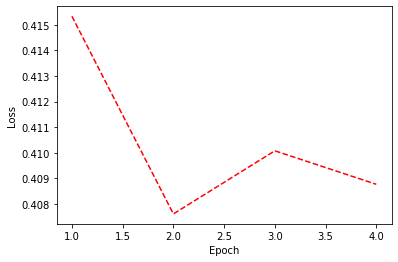

In [80]:
epoch_count = range(1,len(history.history["loss"])+1)

plt.plot(epoch_count,history.history["loss"],'r--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## We can see from above graph the model is suffering from overfitting.

In [85]:
pred = pd.read_csv("predictions.csv")

In [86]:
pred.head()

,Phrase
0,Cogratulations you have won a lottery of 5000$
1,"Hey, buddy you up?"
2,"Want a car loan, dial now 2456235"
3,"Yo, how's the health heard you were sick?"
4,Best Recharge Offers for Your Mobile Operaotor...


In [89]:
clean_pred = clean_sentences(pred)
clear_pred = tokenizer.texts_to_sequences(clean_pred)
clean_pred = sequence.pad_sequences(clear_pred,maxlen=len_max)

y_pred = model.predict_classes(clean_pred)
y_pred

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 131.94it/s]


array([0, 0, 0, 0, 0], dtype=int64)